This notebook takes in a single crystal's dataframe and builds digested ones that are ready for a Neural Network. It also makes some plots along the way. It starts with a slimmed csv file with at least calibrations, luminosities, and timestamps. It's important to note that at this point, some of the lumi measurements are taken a bit far from the calibration times. this can be seen by the difference between the lumi-section time and the calib_time values. The best data probably just consistents of the points where these are close.

Also, I'm running this in the Python 3.6.3 Kernel

In [1]:
#import the stuff
import pandas as pd #dataframes etc
import matplotlib.pyplot as plt #plotting
import numpy as np
from sklearn import preprocessing
from common.utils import TimeSeriesTensor, create_evaluation_df, mape, scale_shrinker

In [8]:
#load the data
year="2016"
df = pd.read_csv('/home/rusack/evans908/FAIR/dataframes/slimmed_df_ieta66_'+year+'.csv', index_col=0)
#there are many times when the xtal is not fired upon. This means the laser_datetime is NaN, 
#and importantly, the lumi columns: int_deliv_inv_ub and int_record_inv_ub would give an erroneous value.
print(df.shape)

/home/rusack/evans908/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(2931120, 36)


In [9]:
df.head()

,Unnamed: 1,iov_idx,fill,temperature,good,t1,seq_datetime,start_ts,stop_ts,hlt_key,...,#run:fill,ls,beamstatus,E(GeV),delivered(/ub),recorded(/ub),avgpu,source,int_deliv_inv_ub,int_record_inv_ub
54000,0,0,4725,23.0,1,1457531954,2016-03-09 13:59:14,1457531929,1457532512,/cdaq/cosmic/commissioning2016/MWGR/MWGR3/v3.0...,...,286520:5575,1193:1193,STABLE BEAMS,4000,0.015146,0.015038,0.0,HFOC,4.144412e+10,3.809226e+10
54000,1,1,4725,23.0,1,1457532763,2016-03-09 14:12:43,1457532747,1457533014,/cdaq/cosmic/commissioning2016/MWGR/MWGR3/v3.0...,...,286520:5575,1193:1193,STABLE BEAMS,4000,0.015146,0.015038,0.0,HFOC,4.144412e+10,3.809226e+10
54000,2,2,4725,23.0,1,1457534139,2016-03-09 14:35:39,1457534120,1457534802,/cdaq/cosmic/commissioning2016/MWGR/MWGR3/v3.0...,...,286520:5575,1193:1193,STABLE BEAMS,4000,0.015146,0.015038,0.0,HFOC,4.144412e+10,3.809226e+10
54000,3,3,4725,23.0,1,1457537501,2016-03-09 15:31:41,1457537481,1457537600,/cdaq/cosmic/commissioning2016/MWGR/MWGR3/v3.0...,...,286520:5575,1193:1193,STABLE BEAMS,4000,0.015146,0.015038,0.0,HFOC,4.144412e+10,3.809226e+10
54000,4,4,4725,23.0,1,1457537939,2016-03-09 15:38:59,1457537919,1457538129,/cdaq/cosmic/commissioning2016/MWGR/MWGR3/v3.0...,...,286520:5575,1193:1193,STABLE BEAMS,4000,0.015146,0.015038,0.0,HFOC,4.144412e+10,3.809226e+10


In [12]:
df.columns

Index(['Unnamed: 1', 'iov_idx', 'fill', 'temperature', 'good', 't1',
       'seq_datetime', 'start_ts', 'stop_ts', 'hlt_key', 'sequence', 'ecal',
       'd_lumi', 'r_lumi', 'bfield', 'feds_included', 'hdf_name', 'inst_lumi',
       'laser_datetime', 'date_y', 'calibration', 'int_inst_lumi', 'p1', 'p2',
       'p3', 'time', '#run:fill', 'ls', 'beamstatus', 'E(GeV)',
       'delivered(/ub)', 'recorded(/ub)', 'avgpu', 'source',
       'int_deliv_inv_ub', 'int_record_inv_ub'],
      dtype='object')

In [17]:
#we'll rename the first column, and create groups based on the current index (crystal index) then we can pick out 1 crystal to look at.
df_rename = df.rename(columns={'Unnamed: 1':'idx'}) #its not a very creative name, but we don't really need the column much
xtal_groups = df.groupby(df_rename.index) #grouped by crystal index
xtal_list = df_rename.index.unique() #a list of all of the crystals in your multi-dataframe


In [18]:
df_54000 = xtal_groups.get_group(54000) #54000 is a well behaved crystal
#now we'll select just the columns we want to study
df_slim = df_54000.loc[:,['laser_datetime','p2','int_deliv_inv_ub','calibration','temperature']]
#set the index to the laser time
df_slim['laser_datetime'] = df_slim['laser_datetime'].astype('datetime64')
df_slim.set_index('laser_datetime', inplace=True)
df_slim.head()

,p2,int_deliv_inv_ub,calibration,temperature
laser_datetime,,,,
NaT,NaN,4.144412e+10,NaN,23.0
NaT,NaN,4.144412e+10,NaN,23.0
NaT,NaN,4.144412e+10,NaN,23.0
NaT,NaN,4.144412e+10,NaN,23.0
NaT,NaN,4.144412e+10,NaN,23.0


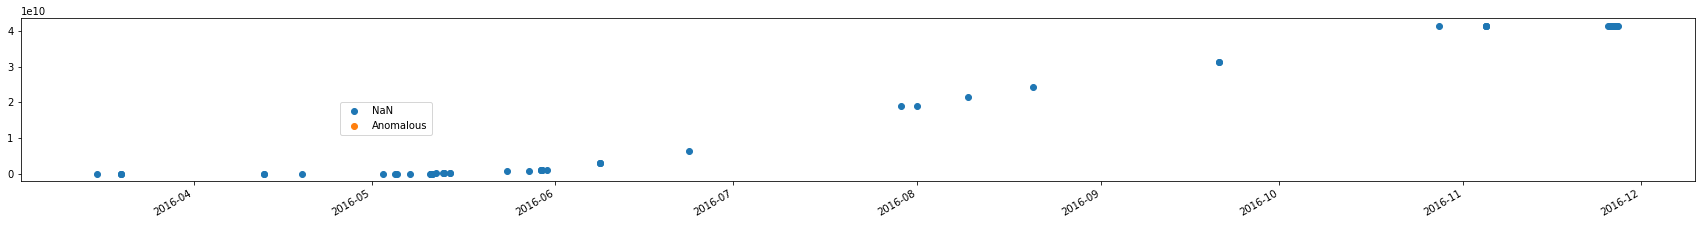

In [22]:
#now we can look for where the calibration is small or NaN
fig, ax = plt.subplots(figsize=(30,3))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.scatter(df_slim[df_slim.calibration.isna()].index, df_slim[df_slim.calibration.isna()].int_deliv_inv_ub, label='NaN')
ax.scatter(df_slim[df_slim.calibration < 0.5].index, df_slim[df_slim.calibration < 0.5].int_deliv_inv_ub, label='Anomalous')

fig.legend(loc=(0.2,0.4))

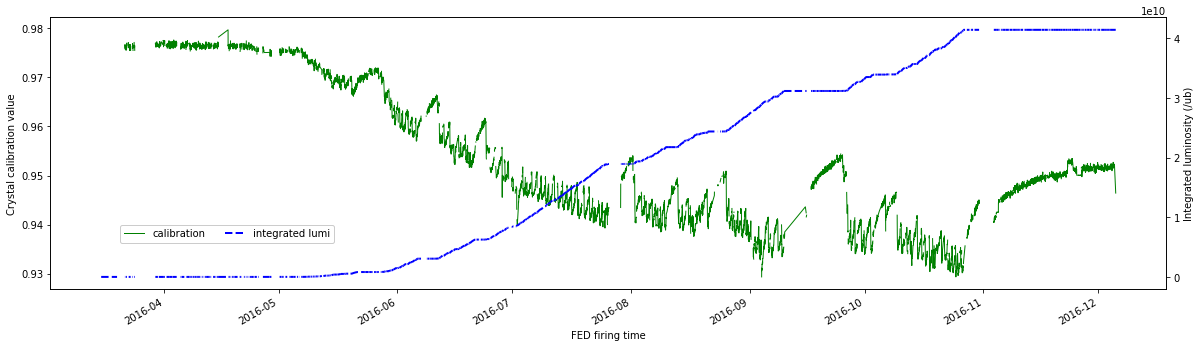

In [28]:
#we can also plot the whole year of data


fig, ax1 = plt.subplots(figsize=(20,5))

ax1.set_ylabel('Crystal calibration value')
ax1.set_xlabel('FED firing time')
#ax1.set_ylim([0.87,0.94])
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

#calibration data
ax1.plot(df_slim.index, df_slim.p2, 
         label='calibration', color='green', linewidth=1, linestyle='solid')

#lumi data on alternate y axis
ax2 = ax1.twinx()
ax2.set_ylabel('Integrated luminosity (/ub)')

ax2.plot(df_slim.index, df_slim.int_deliv_inv_ub, 
         label='integrated lumi', color='blue', linewidth=2, linestyle='dashed')

#combined legend
fig.legend(ncol=2, loc = (0.1,0.3),framealpha=1)

fig.show()

In [29]:
#split the data into training, testing and validating
#select the data range (let's choose may to end of november (for 2016))
data_begin = '2016-05-01 00:00:00'

data_end = '2016-12-01 00:00:00'

df_select = df_slim[(df_slim.index > data_begin) & (df_slim.index < data_end)]

#we can write this out too
df_select.to_csv('../dataframes/df_select_'+year+'.csv')

#select the time ranges for train,valid,test datasets. The boundaries could touch, or you could use a clever boundary to skip an empty spot
df_train_begin = data_begin
df_train_end   = '2016-08-01 00:00:00'

df_valid_begin = df_train_end
df_valid_end   = '2016-10-01 00:00:00'

df_test_begin  = df_valid_end
df_test_end    = data_end

df_train = df_select[(df_select.index < df_train_end) & (df_select.index > df_train_begin)]
df_valid = df_select[(df_select.index < df_valid_end) & (df_select.index > df_valid_begin)]
df_test =  df_select[(df_select.index < df_test_end)  & (df_select.index > df_test_begin)]

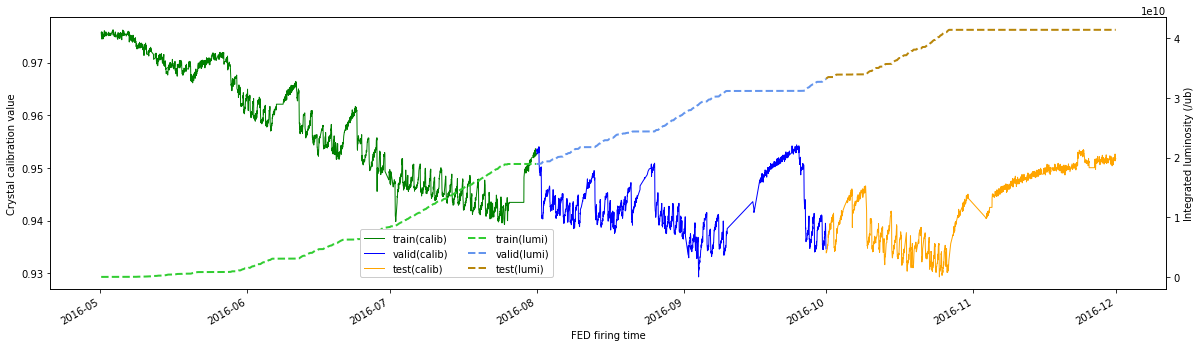

In [31]:
#now lets make a plot of our three datasets

fig, ax1 = plt.subplots(figsize=(20,5))

ax1.set_ylabel('Crystal calibration value')
ax1.set_xlabel('FED firing time')
#ax1.set_ylim([0.87,0.94])
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

#calibration data
ax1.plot(df_train.index, df_train.p2, 
         label='train(calib)', color='green', linewidth=1, linestyle='solid')
ax1.plot(df_valid.index, df_valid.p2, 
         label='valid(calib)', color='blue', linewidth=1, linestyle='solid')
ax1.plot(df_test.index, df_test.p2, 
         label='test(calib)', color='orange', linewidth=1, linestyle='solid')

#lumi data on alternate y axis
ax2 = ax1.twinx()
ax2.set_ylabel('Integrated luminosity (/ub)')

ax2.plot(df_train.index, df_train.int_deliv_inv_ub, 
         label='train(lumi)', color='limegreen', linewidth=2, linestyle='dashed')
ax2.plot(df_valid.index, df_valid.int_deliv_inv_ub, 
         label='valid(lumi)', color='cornflowerblue', linewidth=2, linestyle='dashed')
ax2.plot(df_test.index, df_test.int_deliv_inv_ub, 
         label='test(lumi)', color='darkgoldenrod', linewidth=2, linestyle='dashed')
#combined legend
fig.legend(ncol=2, loc = (0.3,0.2),framealpha=1)

fig.show()

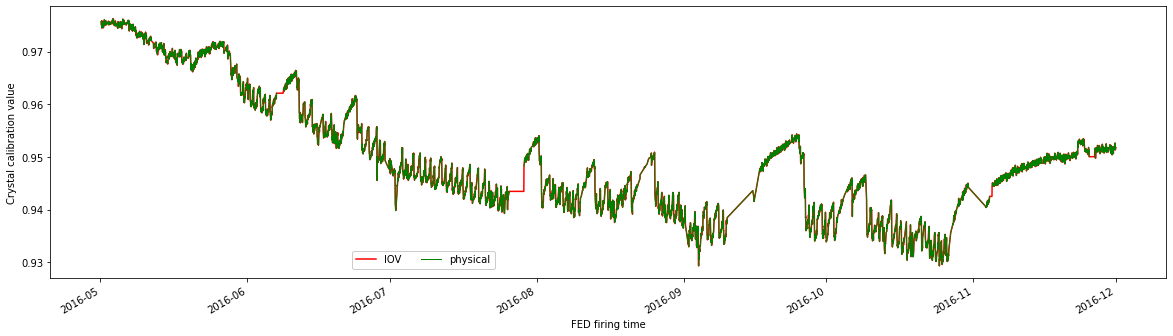

In [34]:
#we can also check the difference between IOV and raw calibrations

fig, ax1 = plt.subplots(figsize=(20,5))

ax1.set_ylabel('Crystal calibration value')
ax1.set_xlabel('FED firing time')
#ax1.set_ylim([0.87,0.94])
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

#calibration data
ax1.plot(df_train.index, df_train.p2, 
         label='IOV', color='red', linewidth=1.5, linestyle='solid')
ax1.plot(df_valid.index, df_valid.p2, 
          color='red', linewidth=1.5, linestyle='solid')
ax1.plot(df_test.index, df_test.p2, 
          color='red', linewidth=1.5, linestyle='solid')

ax1.plot(df_train.index, df_train.calibration, 
         label='physical', color='green', linewidth=1, linestyle='solid')
ax1.plot(df_valid.index, df_valid.calibration, 
          color='green', linewidth=1, linestyle='solid')
ax1.plot(df_test.index, df_test.calibration, 
          color='green', linewidth=1, linestyle='solid')



#combined legend
fig.legend(ncol=2, loc = (0.3,0.2),framealpha=1)


fig.show()

In [35]:
#lets look at the time spacing in the raw data
calib_timedelta = df_select.reset_index().laser_datetime.diff()
calib_td_mins = calib_timedelta.apply(lambda x: x.seconds/60)

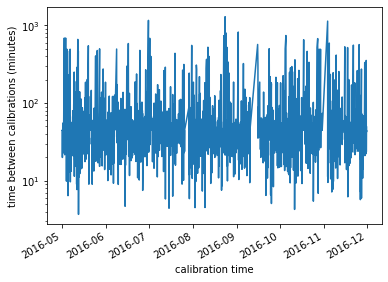

In [36]:
fig8, ax12 = plt.subplots()

ax12.set_ylabel('time between calibrations (minutes)')
ax12.set_xlabel('calibration time')
plt.setp(ax12.get_xticklabels(), rotation=30, horizontalalignment='right')
ax12.set_yscale('log')

ax12.plot(df_select.index, calib_td_mins, label='calib_td')
fig8.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


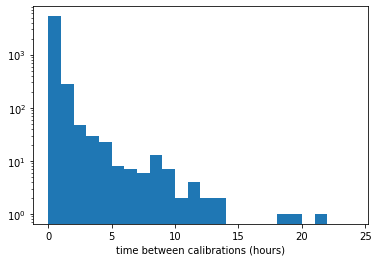

In [37]:
fig9, ax13 = plt.subplots()

calib_td_hrs = calib_timedelta.apply(lambda x: x.seconds/3600)
bins = [bin for bin in range(0, 24+1, 1)]
print(bins)
ax13.hist(calib_td_hrs, bins=bins)
ax13.set_xlabel('time between calibrations (hours)')
plt.setp(ax12.get_xticklabels(), rotation=30, horizontalalignment='right')
ax13.set_yscale('log')

fig9.show()

0         NaN
1    0.742500
2    0.743333
3    0.742778
4    0.747778
Name: laser_datetime, dtype: float64


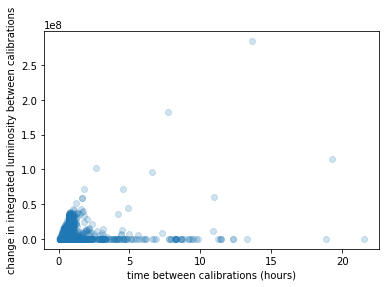

In [39]:
#lets look at the correlation between time delta and the change in integrated luminosity over the period
lumi_delta = df_select.int_deliv_inv_ub.diff()
print(calib_td_hrs.head())
fig, ax = plt.subplots()
ax.set_xlabel('time between calibrations (hours)')
ax.set_ylabel('change in integrated luminosity between calibrations')

ax.scatter(calib_td_hrs, lumi_delta, alpha=0.2)
fig.show()

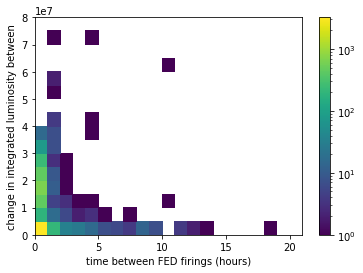

In [40]:
fig, ax = plt.subplots()
import matplotlib.colors as clrs
ax.set_xlabel('time between FED firings (hours)')
ax.set_ylabel('change in integrated luminosity between')

h = ax.hist2d(calib_td_hrs, lumi_delta, bins=[21, 16], range=[[0.0, 21.0], [0.0, 8e7]], norm=clrs.LogNorm())
fig.colorbar(h[3], ax=ax)
fig.show()

In [41]:
#now that we've looked at the raw data, we have to do a few manipulations.
#the first is to convert the data into an evenly spaced timeseries. We'll use a rolling average
import traces as ts

sampling=3600
avg_window = sampling*6
#windows are in seconds
train_calib_avg = ts.TimeSeries(df_train['p2'])\
                                .moving_average(sampling, window_size=avg_window, pandas=True)
train_lumi_avg = ts.TimeSeries(df_train['int_deliv_inv_ub'])\
                                .moving_average(sampling, window_size=avg_window, pandas=True)

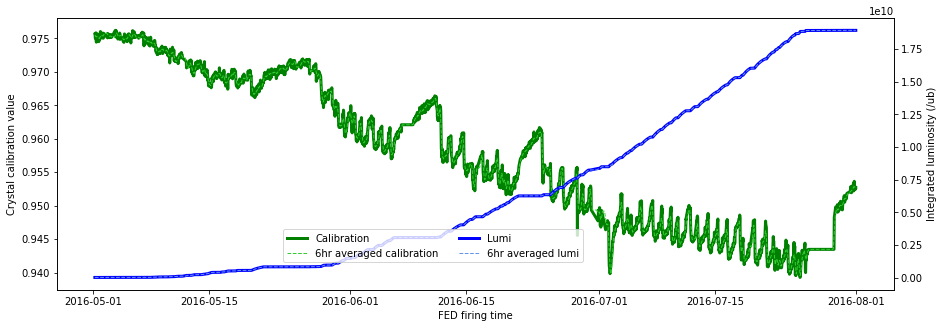

In [42]:
#lets plot the situation
fig2, ax3 = plt.subplots(figsize=(15,5))

ax3.set_ylabel('Crystal calibration value')
ax3.set_xlabel('FED firing time')

#calibration data
ax3.plot(df_train.index, df_train.p2, 
         label='Calibration', color='green', linewidth=3, linestyle='solid')
ax3.plot(train_calib_avg.index, train_calib_avg, 
         label='6hr averaged calibration', color='limegreen', linewidth=1, linestyle='dashed')

#lumi data on alternate y axis
ax4 = ax3.twinx()
ax4.set_ylabel('Integrated luminosity (/ub)')

ax4.plot(df_train.index, df_train.int_deliv_inv_ub, 
         label='Lumi', color='blue', linewidth=3, linestyle='solid')
ax4.plot(train_lumi_avg.index, train_lumi_avg, 
         label='6hr averaged lumi', color='cornflowerblue', linewidth=1, linestyle='dashed')

#combined legend
fig2.legend(ncol=2, loc = (0.3,0.2))

fig2.show()

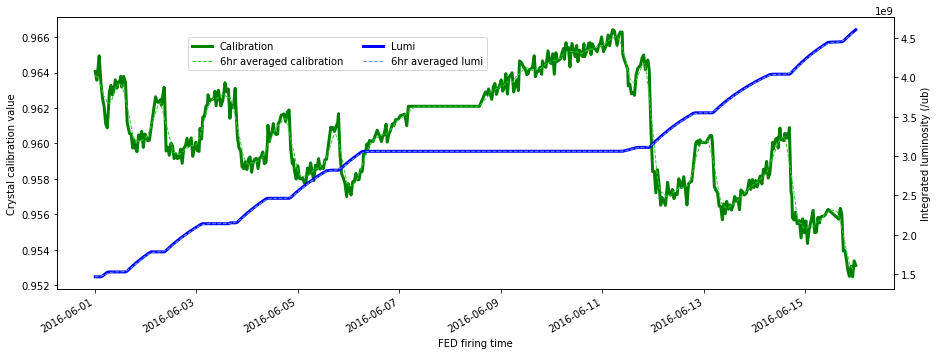

In [44]:
#lets plot a zoomed in view of the situation
fig3, ax5 = plt.subplots(figsize=(15,5))

ax5.set_ylabel('Crystal calibration value')
ax5.set_xlabel('FED firing time')
plt.setp(ax5.get_xticklabels(), rotation=30, horizontalalignment='right')

#zoom
max_time = '2016-06-16 00:00:00'
min_time = '2016-06-01 00:00:00'

df_zoom = df_train[(df_train.index < max_time) & (df_train.index > min_time)]
train_calib_avg_zoom = train_calib_avg[(train_calib_avg.index < max_time) & (train_calib_avg.index > min_time)]
train_lumi_avg_zoom = train_lumi_avg[(train_lumi_avg.index < max_time) & (train_lumi_avg.index > min_time)]

#calibration data
ax5.plot(df_zoom.index, df_zoom.p2, 
         label='Calibration', color='green', linewidth=3, linestyle='solid')
ax5.plot(train_calib_avg_zoom.index, train_calib_avg_zoom, 
         label='6hr averaged calibration', color='limegreen', linewidth=1, linestyle='dashed')

#lumi data on alternate y axis
ax6 = ax5.twinx()
ax6.set_ylabel('Integrated luminosity (/ub)')

ax6.plot(df_zoom.index, df_zoom.int_deliv_inv_ub, 
         label='Lumi', color='blue', linewidth=3, linestyle='solid')
ax6.plot(train_lumi_avg_zoom.index, train_lumi_avg_zoom, 
         label='6hr averaged lumi', color='cornflowerblue', linewidth=1, linestyle='dashed')


#combined legend
fig3.legend(ncol=2, loc = (0.2,0.8))

fig3.show()
#you can see that it isn't perfect when there are gaps in the data.
#this can be tweaked by increasing the sliding average size, but then you lose resolution
#figuring out how to run it with a variable resolution would be tricky.
#but you could also choose a different interpolation technique to try to paste over the gaps

In [48]:
#now that we've explored the interpolation and made interpolated training data,
#we'll follow the same steps for the testing and validation data
valid_calib_avg = ts.TimeSeries(df_valid['p2'])\
                                .moving_average(sampling, window_size=avg_window, pandas=True)
valid_lumi_avg = ts.TimeSeries(df_valid['int_deliv_inv_ub'])\
                                .moving_average(sampling, window_size=avg_window, pandas=True)

test_calib_avg = ts.TimeSeries(df_test['p2'])\
                                .moving_average(sampling, window_size=avg_window, pandas=True)
test_lumi_avg = ts.TimeSeries(df_test['int_deliv_inv_ub'])\
                                .moving_average(sampling, window_size=avg_window, pandas=True)

#now we'll put it all back into dataframes
train = pd.DataFrame()
train['p2'] = train_calib_avg
train['int_deliv_inv_ub'] = train_lumi_avg
train.to_csv('../dataframes/train_avg_'+year+'.csv')

valid = pd.DataFrame()
valid['p2'] = valid_calib_avg
valid['int_deliv_inv_ub'] = valid_lumi_avg
valid.to_csv('../dataframes/valid_avg_'+year+'.csv')

test = pd.DataFrame()
test['p2'] = test_calib_avg
test['int_deliv_inv_ub'] = test_lumi_avg
test.to_csv('../dataframes/test_avg_'+year+'.csv')

In [49]:
#now we need to de-trend the data so that it is flat over time
#for this I'll just apply differencing, since it is pretty simple
train = train.diff().dropna() #we run dropna, since the first row is NaN in a diff
valid = valid.diff().dropna()
test = test.diff().dropna()

train.to_csv('../dataframes/train_diff_'+year+'.csv')
valid.to_csv('../dataframes/valid_diff_'+year+'.csv')
test.to_csv('../dataframes/test_diff_'+year+'.csv')

In [50]:
#now we'll scale the input data for the network
#scale values to between 0 and 1
#for the lumi data, there are many orders of magnitude within the lumi, we want to transform the lumi data to truncate very small values, and convert to log for higher orders of magnitude. and then we'll minmax scale it

scaler = preprocessing.StandardScaler()
y_scaler = preprocessing.StandardScaler() #we'll use the y-scaler later
y_scaler.fit(train[['p2']])
train[['p2', 'int_deliv_inv_ub']] = scaler.fit_transform(train)
valid[['p2', 'int_deliv_inv_ub']] = scaler.transform(valid)
test[['p2', 'int_deliv_inv_ub']] = scaler.transform(test)

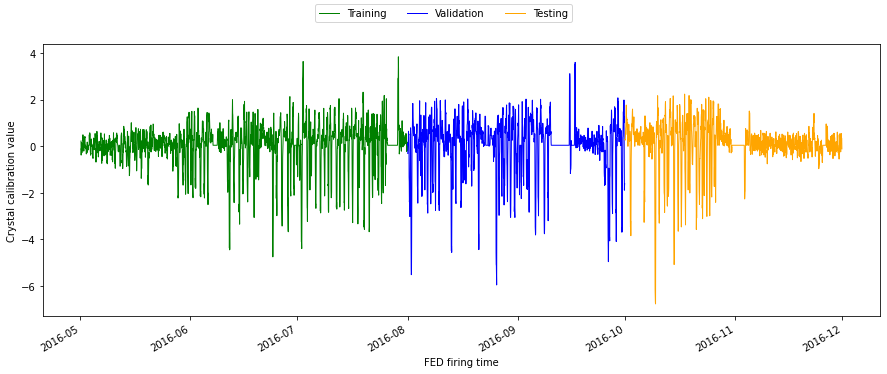

In [51]:
#lets plot the data 1 more time
fig4, ax7 = plt.subplots(figsize=(15,5))

ax7.set_ylabel('Crystal calibration value')
ax7.set_xlabel('FED firing time')
plt.setp(ax7.get_xticklabels(), rotation=30, horizontalalignment='right')

#calibration data
ax7.plot(train.index, train.p2, 
         label='Training', color='green', linewidth=1, linestyle='solid')
ax7.plot(valid.index, valid.p2, 
         label='Validation', color='blue', linewidth=1, linestyle='solid')
ax7.plot(test.index, test.p2, 
         label='Testing', color='orange', linewidth=1, linestyle='solid')
#legend
fig4.legend(ncol=3, loc = 'upper center')
fig4.show()

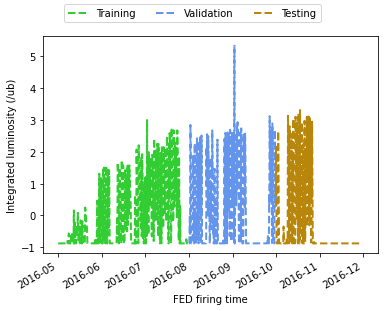

In [52]:
#lumi data on alternate y axis
fig5, ax8 = plt.subplots()
ax8.set_ylabel('Integrated luminosity (/ub)')
ax8.set_xlabel('FED firing time')
plt.setp(ax8.get_xticklabels(), rotation=30, horizontalalignment='right')

ax8.plot(train.index, train.int_deliv_inv_ub, 
         label='Training', color='limegreen', linewidth=2, linestyle='dashed')
ax8.plot(valid.index, valid.int_deliv_inv_ub, 
         label='Validation', color='cornflowerblue', linewidth=2, linestyle='dashed')
ax8.plot(test.index, test.int_deliv_inv_ub, 
         label='Testing', color='darkgoldenrod', linewidth=2, linestyle='dashed')
#legend
fig5.legend(ncol=3, loc = 'upper center')
fig5.show()

In [51]:
#now we'll save the data
train.to_csv('../data/train_rescale_'+year+'.csv')
test.to_csv('../data/test_rescale_'+year+'.csv')
valid.to_csv('../data/valid_rescale_'+year+'.csv')